# Fuzzed vs Vanilla flight path analysis

# Fuzzed vs Vanilla flight path analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw

### We generate the csv files via the ulog2csv utility and target the vehicle_local_position message

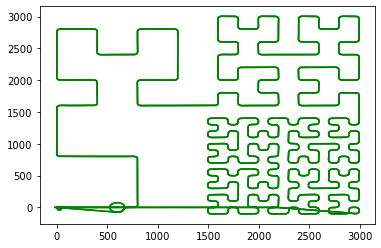

In [4]:
vanilla_pos_df = pd.read_csv("vanilla/vl1_vehicle_local_position_0.csv")
plt.plot(vanilla_pos_df["y"], vanilla_pos_df["x"], "g")
vanilla_pos_df2 = pd.read_csv("vanilla/vl2_vehicle_local_position_0.csv")
plt.plot(vanilla_pos_df2["y"], vanilla_pos_df2["x"], "g")
vanilla_pos_df3 = pd.read_csv("vanilla/vl3_vehicle_local_position_0.csv")
plt.plot(vanilla_pos_df3["y"], vanilla_pos_df3["x"], "g")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

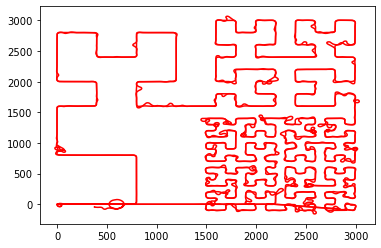

In [6]:
fuzzed_pos_df = pd.read_csv("fuzzed/fzl1_vehicle_local_position_0.csv")
plt.plot(fuzzed_pos_df["y"], fuzzed_pos_df["x"], "r")
fuzzed_pos_df2 = pd.read_csv("fuzzed/fzl2_vehicle_local_position_0.csv")
plt.plot(fuzzed_pos_df2["y"], fuzzed_pos_df2["x"], "r")
plt.show

In [8]:
def df2path(df):
    return np.transpose(np.stack((df["x"], df["y"])))

def log2path_standard(isVanilla, index):
    """Takes vanilla or fuzzed index and returns a 2d array of x,y coordinates"""
    prefix = "standard_autopilot/vanilla/vl" if isVanilla else "standard_autopilot/fuzzed/fzl"
    pdf = pd.read_csv(prefix + str(index) + "_vehicle_local_position_0.csv")
    return df2path(pdf)

def log2path_rcac(isVanilla, index):
    """Takes vanilla or fuzzed index and returns a 2d array of x,y coordinates"""
    prefix = "rcac_autopilot/vanilla/vl" if isVanilla else "rcac_autopilot/fuzzed/fzl"
    pdf = pd.read_csv(prefix + str(index) + "_vehicle_local_position_0.csv")
    return df2path(pdf)

In [10]:
vanilla_path  = log2path_standard(True, 1)
fuzzed_path  = log2path_standard(False, 1)
vf_distance, vf_path = fastdtw(vanilla_path, fuzzed_path)
print(vf_distance)

351001.09118142916


In [14]:
# distances between curves within the vanilla class
vanilla_path2 = log2path_standard(True, 2) 
vanilla_path3 = log2path_standard(True, 3) 
vv_distance1, vv_path1 = fastdtw(vanilla_path, vanilla_path2)
print(vv_distance1)
vv_distance2, vv_path2 = fastdtw(vanilla_path, vanilla_path3)
print(vv_distance2)
vv_distance3, vv_path3 = fastdtw(vanilla_path2, vanilla_path3)
print(vv_distance3)

16749.098915338152
75121.7668107414
75633.34585249785


In [12]:
# distances between the curves in the fuzzed class
fuzzed_path2 = log2path_standard(False, 2) 
fuzzed_path3 = log2path_standard(False, 3) 
ff_distance1, ff_path1 = fastdtw(fuzzed_path, fuzzed_path2)
print(ff_distance1)
ff_distance2, ff_path2 = fastdtw(fuzzed_path, fuzzed_path3)
print(ff_distance2)
ff_distance3, ff_path3 = fastdtw(fuzzed_path2, fuzzed_path3)
print(ff_distance3)


592775.3690882081
458605.17798366887
544286.8856147868


### Now we can construct a similarity matrix with the dynamic-time-warping as a distance metric
The matrix will be upper-triangular with 0s along the diagnonal as in the example below

In [15]:
mat = np.zeros((5,5))
for i in range(5):
    for j in range(1, 5-i):
        mat[i, i+j] = 1
print(mat)

[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [16]:
vanilla_simmat = np.zeros((5,5))
for i in range(5):
    for j in range(1, 5-i):
        p1 = log2path_standard(True, i)
        p2 = log2path_standard(True, j)
        wdist, dtwpath = fastdtw(p1, p2) 
        vanilla_simmat[i, i+j] = wdist
print(vanilla_simmat)

[[    0.         78318.22597352 78636.15958638 21532.62338518
  20480.52512101]
 [    0.             0.             0.         16749.09891534
  75121.76681074]
 [    0.             0.             0.         16749.09891534
      0.        ]
 [    0.             0.             0.             0.
  75121.76681074]
 [    0.             0.             0.             0.
      0.        ]]


In [28]:
from statistics import * 
alldists = [i for i in filter(lambda x: x != 0, vanilla_simmat.flat)]
vanilla_m = mean(alldists)
print(m)
vanilla_simmat/vanilla_m

47838.658189781774


array([[0.        , 1.63713258, 1.64377854, 0.45010927, 0.42811663],
       [0.        , 0.        , 0.        , 0.3501164 , 1.57031509],
       [0.        , 0.        , 0.        , 0.3501164 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.57031509],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

### fuzz crash rate 2/10

In [26]:
fuzzed_simmat = np.zeros((8,8))
for i in range(8):
    for j in range(1, 8-i):
        p1 = log2path_standard(False, i)
        p2 = log2path_standard(False, j)
        wdist, dtwpath = fastdtw(p1, p2) 
        fuzzed_simmat[i, i+j] = wdist
print(fuzzed_simmat)

[[     0.         564077.49506085 475253.58490408 454590.04131215
  536050.43823219 446122.44264294 432097.10466223 471589.54262584]
 [     0.              0.              0.         592775.36908821
  458605.17798367 478012.38820639 443976.38234811 434867.4044559 ]
 [     0.              0.              0.         592775.36908821
       0.         544286.88561479 572063.44377332 486542.90152473]
 [     0.              0.              0.              0.
  458605.17798367 544286.88561479      0.         388050.61060918]
 [     0.              0.              0.              0.
       0.         478012.38820639 572063.44377332 388050.61060918]
 [     0.              0.              0.              0.
       0.              0.         443976.38234811 486542.90152473]
 [     0.              0.              0.              0.
       0.              0.              0.         434867.4044559 ]
 [     0.              0.              0.              0.
       0.              0.              0.  

In [29]:
fuzzed_simmat/vanilla_m

array([[ 0.        , 11.79124826,  9.9345091 ,  9.50256672, 11.20538198,
         9.32556346,  9.03238345,  9.85791743],
       [ 0.        ,  0.        ,  0.        , 12.39113703,  9.58649752,
         9.99217801,  9.28070308,  9.09029268],
       [ 0.        ,  0.        ,  0.        , 12.39113703,  0.        ,
        11.37755335, 11.95818331, 10.17049641],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  9.58649752,
        11.37755335,  0.        ,  8.11165332],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         9.99217801, 11.95818331,  8.11165332],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  9.28070308, 10.17049641],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  9.09029268],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])